In [19]:
from pulp import *
import matplotlib.pyplot as plt
import numpy as np
from time import time

# Let $P_{id}= 
\begin{cases}
    1& \text{if } \text{person } i \text{ works day } d\\
    0              & \text{otherwise}
\end{cases}$

# \begin{bmatrix}
P_{11} & P_{12} & ... & P_{1D}\\
... & ... & ... & ...\\
P_{N1} & P_{N2} & ... & P_{ND}\\
\end{bmatrix}

# Constraint 1: Make sure that enough people work each day

# $\sum_{i=1}^{n} P_{id} = 2 \text{ for } d=1,...,D$

In [20]:
def add_enough_workers_constraint(prob: pulp.LpProblem, p_vars: list, num_employees: int, num_days: int, num_shifts_per_day: int):
    #for each day...
    for d in range(num_days):
        #make sure that enough people are working
        prob += sum([p_vars[i][d] for i in range(num_employees)]) == num_shifts_per_day

# Constraint 2: Make sure that work is distributed evenly

# $L \leq \sum_{d=1}^{D} P_{id} \leq U\text{ for } n=1,...,N$

In [21]:
def add_equal_work_constraint(prob: pulp.LpProblem, p_vars: list, num_employees: int, num_days: int, num_shifts_per_day: int):
    #get the upper and lower limits of number of days each employee will work
    lower_days_worked = int(num_shifts_per_day*num_days/num_employees)
    upper_days_worked = lower_days_worked + 1
    
    #for each employee...
    for n in range(num_employees):
        #make sure that they are working AT MOST upper_days_worked
        prob += sum(p_vars[n]) <= upper_days_worked
        
        #make sure that they are working AT LEAST lower_days_worked
        prob += sum(p_vars[n]) >= lower_days_worked

# Constraint 3: Make sure that time-off requests respected

# $P_{id} = 0\text{ if person } i \text{ cannot work on day } d$

In [22]:
def add_time_off_constraint(prob: pulp.LpProblem, p_vars: list, time_off_requests: list, num_employees: int, num_days: int):
    #for each time off request...
    for employee, day in time_off_requests:
        #add constraint that this person will not work on this day
        prob += p_vars[employee][day] == 0

# Objective Function: Try to match as many shift preferences as possible

In [23]:
def get_number_matching_shifts(prob: pulp.LpProblem, p_vars: list, shift_preferences: list, num_employees: int, num_days: int):
    #create initial preference list, all 0
    preference_list = [0 for _ in range(num_employees*num_days)]
    
    #for each shift preference...
    obj = 0
    for employee, day in shift_preferences:
        #add this to optimization problem
        obj += p_vars[employee][day]
    prob += obj

# Driver Code

In [24]:
def get_shifts(num_days: int, num_employees: int, num_shifts_per_day: int, time_off_requests: list, shift_preferences: list):
    #init problem and define all vars
    prob = LpProblem("shifts", LpMaximize)
    p_vars = [[] for _ in range(num_employees)]
    leading_zeros_employees = '0'*int(np.log10(num_employees-1))
    leading_zeros_days = '0'*int(np.log10(num_days-1))
    for n in range(num_employees):
        for d in range(num_days):
            var_name = f'P_{(leading_zeros_employees+str(n))[-len(leading_zeros_employees)-1:]}_{(leading_zeros_days+str(d))[-len(leading_zeros_days)-1:]}'
            v = LpVariable(var_name, 0, 1, LpInteger)
            p_vars[n].append(v)
            
    get_number_matching_shifts(prob, p_vars, shift_preferences, num_employees, num_days)
    
    add_enough_workers_constraint(prob, p_vars, num_employees, num_days, num_shifts_per_day)
    
    add_equal_work_constraint(prob, p_vars, num_employees, num_days, num_shifts_per_day)
    
    add_time_off_constraint(prob, p_vars, time_off_requests, num_employees, num_days)
    
    start = time()
    status = prob.solve()
    end = time()
    seconds = end - start
    print('Status:', 'success' if status==1 else 'failure')
    print('Seconds:' if seconds > 1 else 'Milliseconds:', round(seconds,2) if seconds > 1 else int(seconds*1000))
    
    shifts = np.array([int(v.varValue) for v in prob.variables()]).reshape(num_employees, num_days)

    plt.figure()
    plt.figure(figsize=(num_employees*1.5, num_days*1.5))
    im = plt.imshow(shifts, aspect='equal', cmap='gray')
    ax = plt.gca()

    ax.set_xticks(np.arange(0, num_days, 1))
    ax.set_yticks(np.arange(0, num_employees, 1))

    # Labels for major ticks
    ax.set_xticklabels([f"D{i}" for i in range(1,num_days+1)], fontsize=16)
    ax.set_yticklabels([f"E{i}" for i in range(1,num_employees+1)], fontsize=16)

    # Minor ticks
    ax.set_xticks(np.arange(-.5, num_days, 1), minor=True)
    ax.set_yticks(np.arange(-.5, num_employees, 1), minor=True)

    # Gridlines based on minor ticks
    ax.grid(which='minor', color='gray', linestyle='-', linewidth=2)
    
    num_prefs_matched = int(prob.objective.value())
    plt.title(f'{num_prefs_matched}/{len(shift_preferences)} Preferences Matched', fontsize=25)
    
    print('===============================')
    for i, time_off_request in enumerate(time_off_requests):
        print(f"E{time_off_request[0]+1} cannot work on D{time_off_request[1]+1}")
    
    print('===============================')
    for i, shift_pref in enumerate(shift_preferences):
        print(f"E{shift_pref[0]+1} prefers working on D{shift_pref[1]+1}")
    print('===============================')
        
    plt.show()
    
    return prob, shifts

In [25]:
#play around with these
num_days = 7
num_employees = 5
num_shifts_per_day = 2

time_off_requests = [
    [0,0],
    [0,1],
    [2,0],
    [3,0],
    [4,5]
]

shift_preferences = [
    [0,2],
    [0,4],
    [1,4],
    [2,1],
    [4,0] 
]

Status: success
Milliseconds: 87
E1 cannot work on D1
E1 cannot work on D2
E3 cannot work on D1
E4 cannot work on D1
E5 cannot work on D6
E1 prefers working on D3
E1 prefers working on D5
E2 prefers working on D5
E3 prefers working on D2
E5 prefers working on D1


<Figure size 432x288 with 0 Axes>

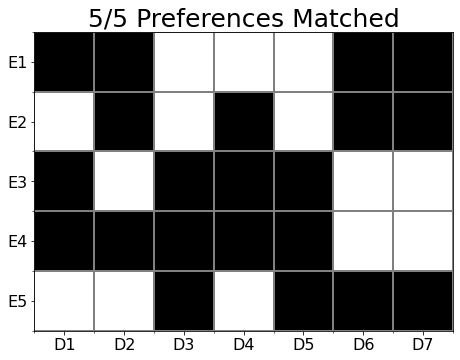

In [26]:
prob, shifts = get_shifts(num_days, num_employees, num_shifts_per_day, time_off_requests, shift_preferences)

# Harder Case

In [9]:
#play around with these
num_days = 21
num_employees = 10
num_shifts_per_day = 4

time_off_requests = []
for n in range(num_employees):
    p = np.random.random()
    if p < 0.5:
        time_off_requests.append([n, int(np.random.random()*num_days)])

shift_preferences = []
for n in range(num_employees):
    p = np.random.random()
    if p < 0.8:
        pref = [n, int(np.random.random()*num_days)]
        if pref not in time_off_requests:
            shift_preferences.append(pref)

In [10]:
time_off_requests

[[1, 0], [4, 18], [5, 0], [6, 5], [7, 6], [8, 14]]

In [11]:
shift_preferences

[[0, 11], [1, 11], [2, 0], [3, 19], [4, 9], [5, 18], [7, 20], [8, 10], [9, 6]]

Status: success
Milliseconds: 108
E2 cannot work on D1
E5 cannot work on D19
E6 cannot work on D1
E7 cannot work on D6
E8 cannot work on D7
E9 cannot work on D15
E1 prefers working on D12
E2 prefers working on D12
E3 prefers working on D1
E4 prefers working on D20
E5 prefers working on D10
E6 prefers working on D19
E8 prefers working on D21
E9 prefers working on D11
E10 prefers working on D7


<Figure size 432x288 with 0 Axes>

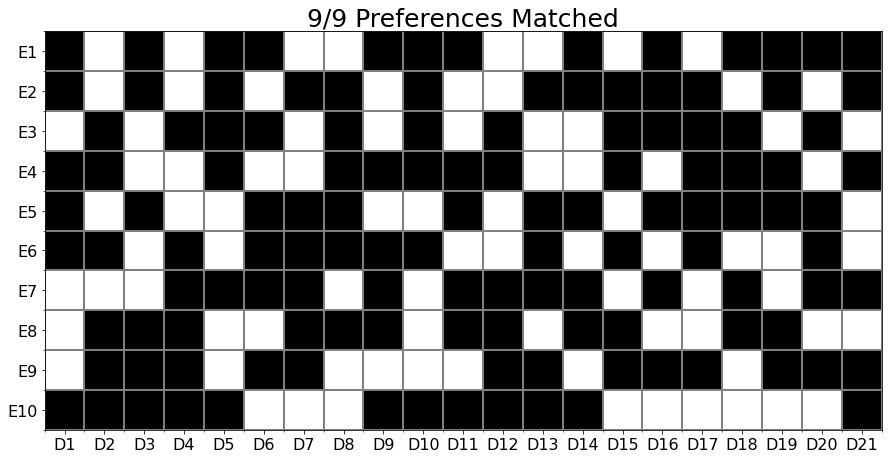

In [12]:
prob, shifts = get_shifts(num_days, num_employees, num_shifts_per_day, time_off_requests, shift_preferences)

In [13]:
#number of shifts per employee
shifts.sum(axis=1)

array([8, 8, 9, 8, 8, 9, 8, 9, 8, 9])

In [14]:
#number of shifts per day
shifts.sum(axis=0)

array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])

# Boss Level

In [15]:
#play around with these
num_days = 180
num_employees = 50
num_shifts_per_day = 15

time_off_requests = []
for n in range(num_employees):
    p = np.random.random()
    if p < 0.9:
        time_off_requests.append([n, int(np.random.random()*num_days)])

shift_preferences = []
for n in range(num_employees):
    p = np.random.random()
    if p < 0.8:
        pref = [n, int(np.random.random()*num_days)]
        if pref not in time_off_requests:
            shift_preferences.append(pref)

In [16]:
len(time_off_requests)

41

In [17]:
len(shift_preferences)

39

Status: success
Seconds: 1.68
E1 cannot work on D164
E2 cannot work on D128
E3 cannot work on D84
E4 cannot work on D89
E7 cannot work on D103
E8 cannot work on D115
E9 cannot work on D129
E10 cannot work on D55
E11 cannot work on D81
E12 cannot work on D103
E13 cannot work on D170
E15 cannot work on D79
E16 cannot work on D156
E17 cannot work on D142
E19 cannot work on D41
E20 cannot work on D156
E22 cannot work on D180
E23 cannot work on D107
E24 cannot work on D131
E25 cannot work on D57
E26 cannot work on D72
E27 cannot work on D172
E29 cannot work on D178
E30 cannot work on D59
E31 cannot work on D90
E32 cannot work on D81
E34 cannot work on D127
E36 cannot work on D51
E37 cannot work on D118
E38 cannot work on D103
E39 cannot work on D13
E40 cannot work on D128
E41 cannot work on D43
E42 cannot work on D36
E43 cannot work on D114
E44 cannot work on D17
E45 cannot work on D52
E46 cannot work on D112
E47 cannot work on D23
E49 cannot work on D42
E50 cannot work on D139
E1 prefers w

<Figure size 432x288 with 0 Axes>

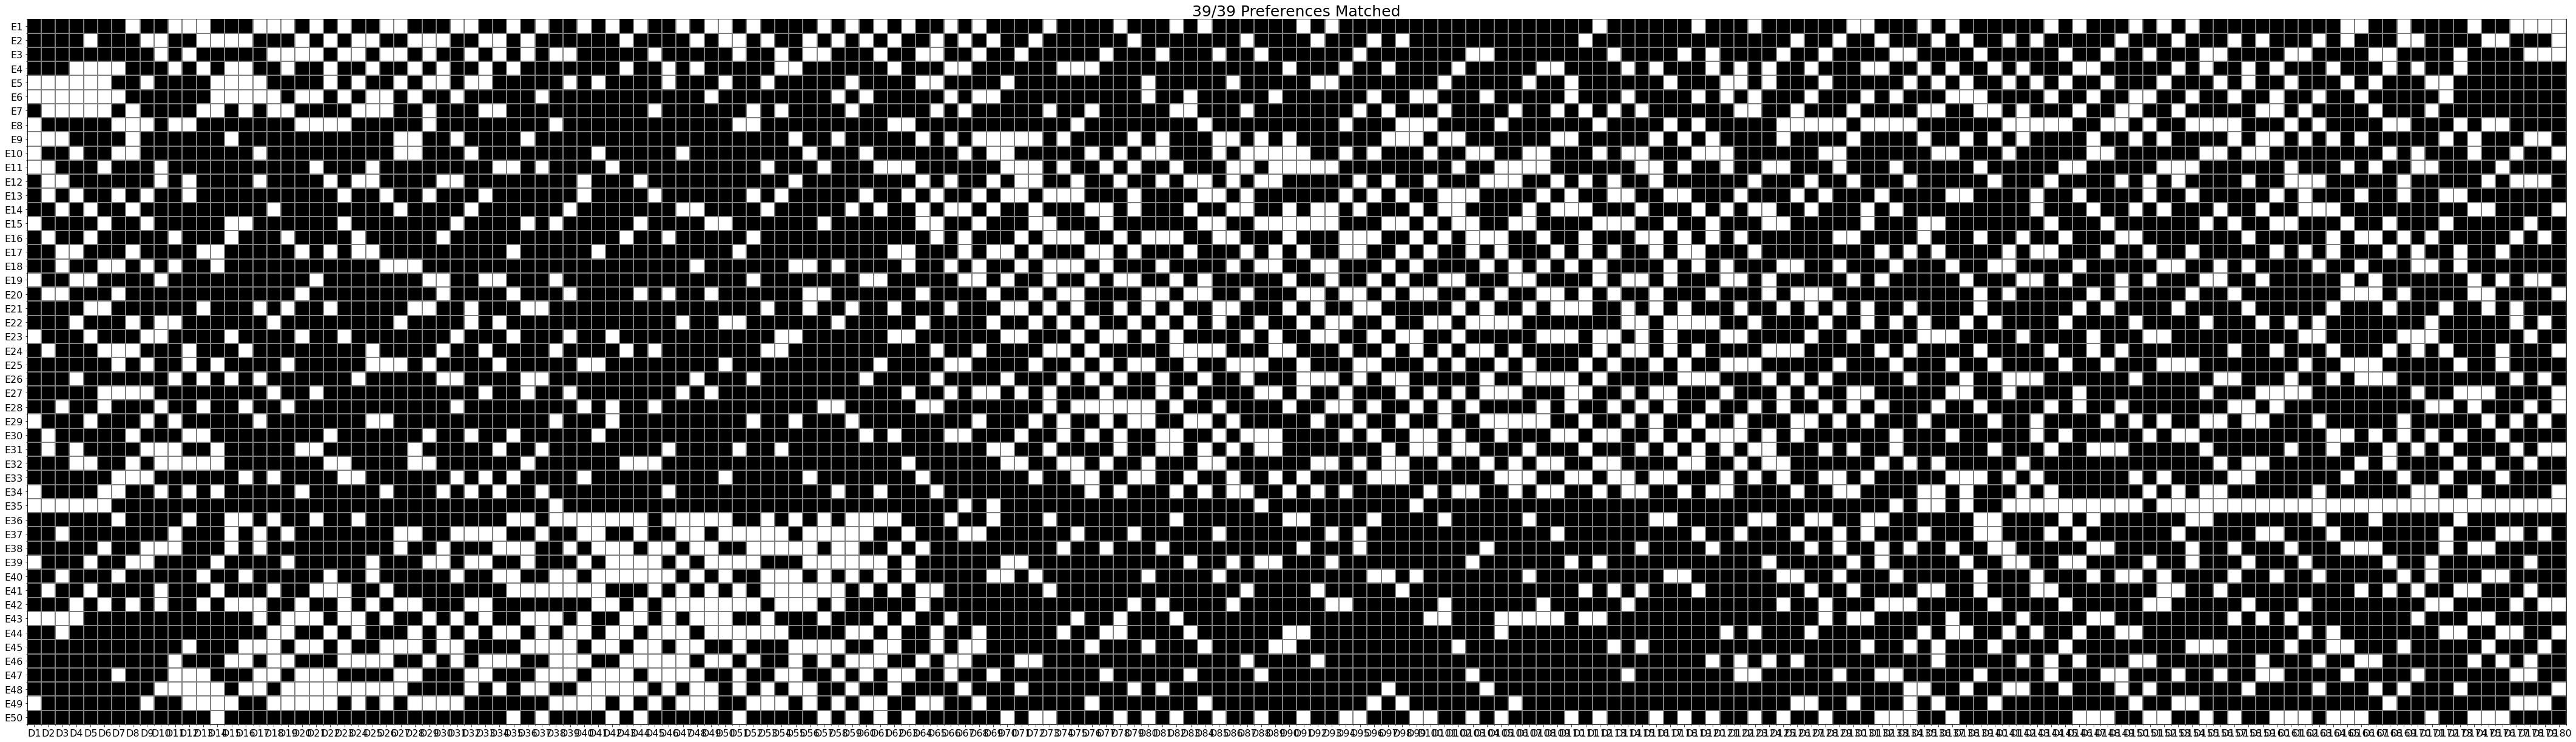

In [18]:
prob, shifts = get_shifts(num_days, num_employees, num_shifts_per_day, time_off_requests, shift_preferences)